# Demo 1: Flow

Flow is a fundamental driver of processes in the surface and subsurface. In this set of demonstrations we will introduce

  * Richards Model for variably saturated subsurface flow
  * Diffusion Wave model for overland flow (surface flow)
  * A fully coupled (integrated hydrology) model

For each model we will provide the mathematical equations, highlight information about the discretization and provide tips on setting boundary conditions, initial conditions, source terms and key parameters.

## Subsurface Flow (Richards Equation)

Richards (1931) model for variably saturated flow:

$\newcommand{porosity}{\phi}$
$\newcommand{dens}{n_l}$
$\newcommand{sat}{s}$
$\newcommand{flux}{\mathbf{q}}$
$\newcommand{krel}{k_r}$
$\newcommand{kabs}{\kappa}$
$\newcommand{viscosity}{\mu}$

$$
\begin{align}
  \frac{\partial}{\partial t} (\porosity \dens \sat) &+ \nabla \cdot \flux = 0 \\
  \flux &= - \dens \frac{\krel \kabs}{\viscosity} (\nabla p + \rho \mathbf{g})
\end{align}
$$




### Model Setup: Infiltration into a soil column (1D) 
These tests demonstrate solution of Richards equation on a single column. A single column of cells, oriented vertically.

#### Initial conditions 

- hydrostatic profile with the water table at 3m. 

#### Boundary condition

- Infilitration is turned on and water fills the domain. Inward flux is set to 0.05 [mol s].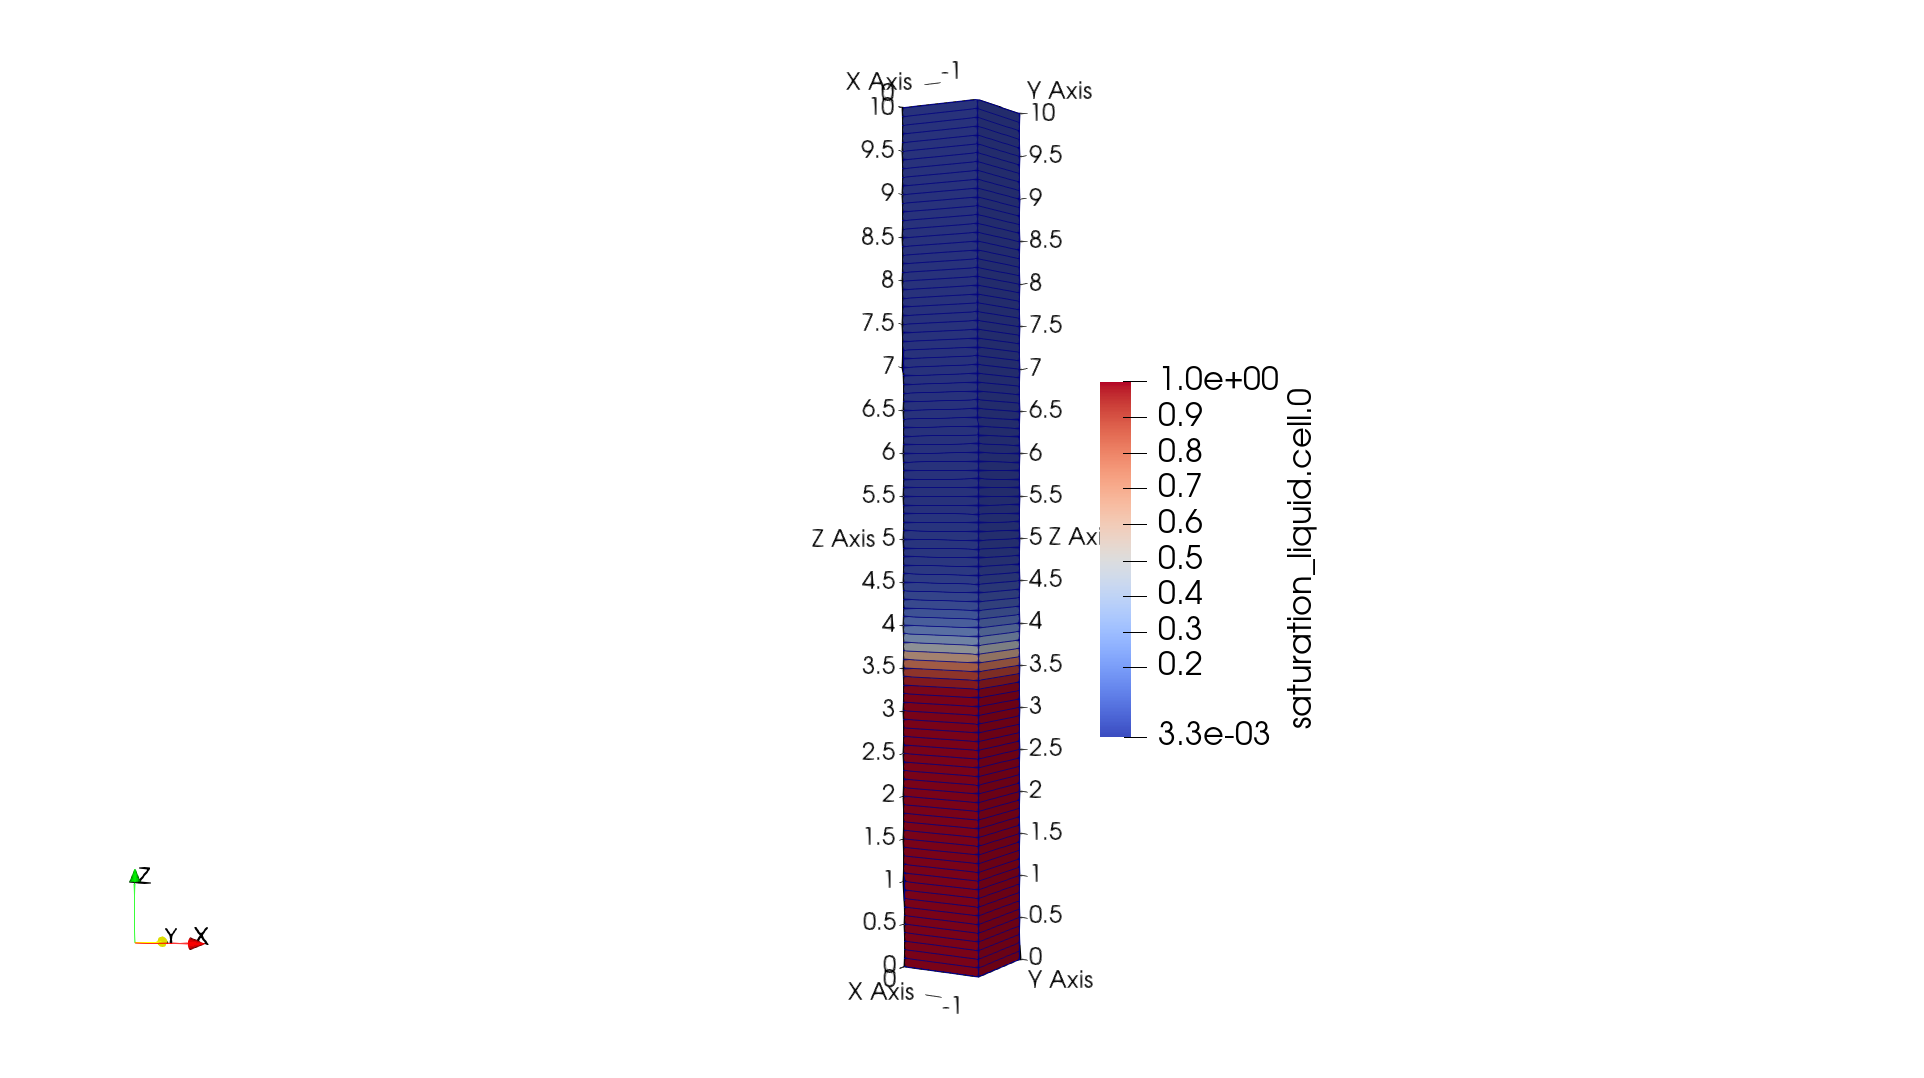

### Simulation Results 
After running the simulation we can plot the results using some of the python utilities provided by ATS. In this case we will plot the saturation as a function of depth, at several times.

In [37]:
%matplotlib inline

In [42]:
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
import ats_xdmf
import plot_column_data
import numpy as np
from matplotlib import pyplot as plt

In [43]:
def plot(dirname, title):
    """A generic plotting function that plots saturation as a function of depth."""
    fig = plt.figure()

    vis = ats_xdmf.VisFile(dirname, output_time_unit='d')
    vis.loadMesh(columnar=True)
    
    # plot the solution
    ax = fig.subplots(1,1)
    plot_column_data.plot_subsurface(vis, ['saturation_liquid',], ax, label='days', cmap='jet')
    ax.set_title(title)
    ax.set_xlabel('saturation [-]')
    ax.set_ylabel('z [m]')

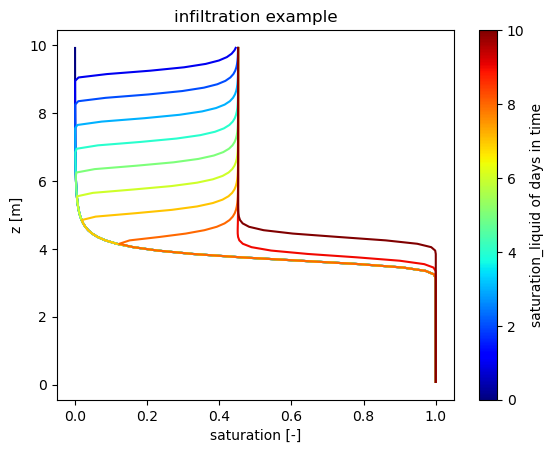

In [44]:
plot("./richards/run_richards/", "infiltration example")

<Axes: xlabel='time [d]'>

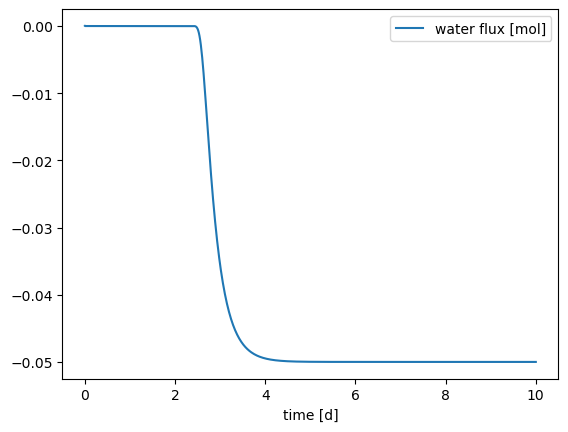

In [48]:
import numpy as np
from matplotlib import pyplot as plt

flux_data = pandas.read_csv("./richards/run_richards/observation_flux.dat", comment='#')
flux_data.plot("time [d]","water flux [mol]")


## Overland Flow (Diffusion Wave Equation)

Diffusion wave model for overland flow

$\newcommand{pondeddepth}{h_w}$
$\newcommand{watersource}{q_w}$
$\newcommand{flux}{{\bf U_w}}$
$\newcommand{manning}{n_{man}}$


$$
\begin{align}
  \frac{\partial \pondeddepth}{\partial t}  &+ \nabla \cdot \pondeddepth \flux = \watersource \\
  \flux &= -\displaystyle\frac{\pondeddepth^{2/3}}{\manning\left(||\nabla Z_s|| + \varepsilon\right)^{1/2}}
  \nabla\left(Z_s + \pondeddepth\right)
\end{align}
$$


$\pondeddepth$ - ponded depth
$\watersource$ - water source
$Z_s$ - surface elevation
$\manning$ - Manning’s coefficient


### Model Setup: Rainfall on a Hillslope 

This demonstration simulates a rainfall event over a hillslope domain with different boundary conditions. 

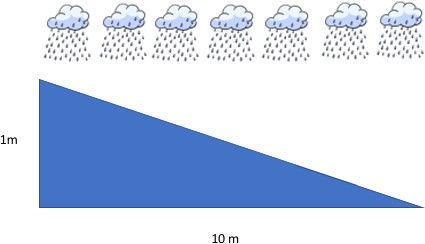

#### Boundary conditions:

A complete description of supported boundary conditions is provided in the documentation of the input specification online, e.g., for flow BCs see [ATS input specification v1.2 - flow-specific-boundary-conditions](https://github.com/amanzi/ats/blob/master/docs/documentation/source/input_spec/ATSNativeSpec_1_2.rst#flow-specific-boundary-conditions).  Here we focus on four important boundary conditions for surface flow.

**No-Flow**: 

The default boundary condition is no-flow, and is set with an empty list,

```xml
<ParameterList name="boundary conditions" type="ParameterList">
</ParameterList>
```

**Critical Depth**: 

This is an _outlet_ boundary condition which looks to set an outward flux to take away runoff. This condition is given by the following condition on outward flux 

$$q = h^{3/2}\sqrt{g} $$

It is described in the input spec as

```xml
<ParameterList name="boundary conditions" type="ParameterList">
  <ParameterList name="critical depth" type="ParameterList">
    <ParameterList name="outlet" type="ParameterList">
      <Parameter name="regions" type="Array(string)" value="{right side}" />
    </ParameterList>
  </ParameterList>
</ParameterList>
```


**Zero Head Gradient:**

This is an _outlet_ boundary condition which looks to enforce the condition that

$$ \nabla h \cdot n = 0 $$

but should only be used on boundaries where

$$ \nabla Z \cdot n  < 0 $$

This is expressed in the input file as

```xml
<ParameterList name="boundary conditions" type="ParameterList">
  <ParameterList name="zero gradient" type="ParameterList">
    <ParameterList name="outlet" type="ParameterList">
      <Parameter name="regions" type="Array(string)" value="{right side}" />
    </ParameterList>
  </ParameterList>
</ParameterList>
```    

**Max Head or Surface Seepage:**

This allows water to flow out once the ponded depth exceeds the specified head, but does not allow flow back into the domain:

if ${\bf U}_w\cdot n < 0$ then we set ${\bf U}_w\cdot n = 0$

if $ h > h_{max}$ then we set $h = h_{max}$

And is written in the input file as

```xml
<ParameterList name="boundary conditions" type="ParameterList">
  <ParameterList name="seepage face head" type="ParameterList">
    <ParameterList name="outlet" type="ParameterList">
      <Parameter name="regions" type="Array(string)" value="{right side}" />
      <ParameterList name="boundary head" type="ParameterList">
        <ParameterList name="function-constant" type="ParameterList">
          <Parameter name="value" type="double" value="0.025" />
        </ParameterList>
      </ParameterList>
    </ParameterList>
  </ParameterList>
</ParameterList>
```

#### Simulation Results

In [22]:
%matplotlib inline
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
import ats_xdmf
import colors
import numpy as np
from matplotlib import pyplot as plt
import pandas

In [23]:
def plot_surface(directory):
    """A generic plotting script plotting ponded depth and discharge/runoff"""
    vis = ats_xdmf.VisFile(directory, domain='surface')
    vis.loadMesh(order=['x','y'])

    cm = colors.cm_mapper(vis.times[0], vis.times[-1], cmap='jet')
    x = vis.centroids[:,0]

    fig, ax = plt.subplots(1,2, figsize=(14,3))

    # This simply gets a colorbar axis
    C = [[0,0],[0,0]]
    C3 = ax[0].contourf(C, vis.times, cmap='jet')
    ax[0].cla()  

    pd = vis.getArray('surface-ponded_depth')
    elev = vis.get('surface-elevation', '0')

    #ax[0].plot(x, elev, 'k')
    for i,time in enumerate(vis.times):
        #ax[0].plot(x, elev + pd[i,:], color=cm(i))
        #print(cm(i))
        ax[0].plot(x, pd[i,:], color=cm(time))

    ax[0].set_xlabel('x-coordinate [m]')
    ax[0].set_ylabel('ponded depth [m]')
    
    hydro = np.loadtxt(os.path.join(directory, 'surface_outlet_flux.dat'), skiprows=11)
    hydro = np.transpose(hydro)
    ax[1].plot(hydro[0][:]/60.0, hydro[1][:], 'b')
    ax[1].set_xlabel('time [min]')
    ax[1].set_ylabel('discharge flow rate [mol/s]')
    
    cbar = plt.colorbar(C3, ax=ax[0])
    cbar.ax.set_ylabel("time [s]")
    
    plt.tight_layout()
    plt.show()

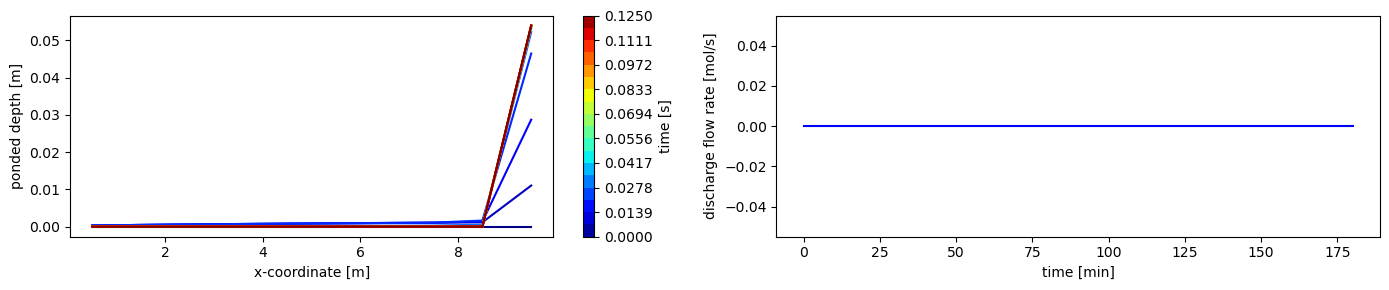

In [24]:
plot_surface("overland_flow/run_no_flow_results")

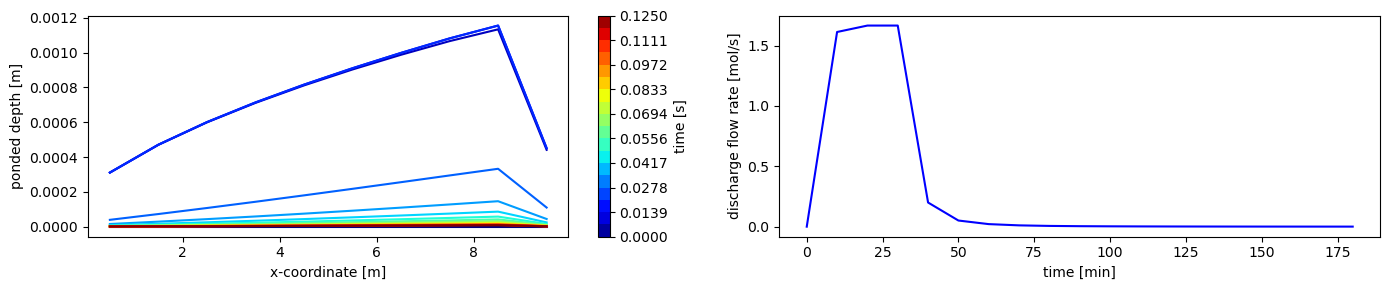

In [25]:
plot_surface("overland_flow/run_critical_depth_results")

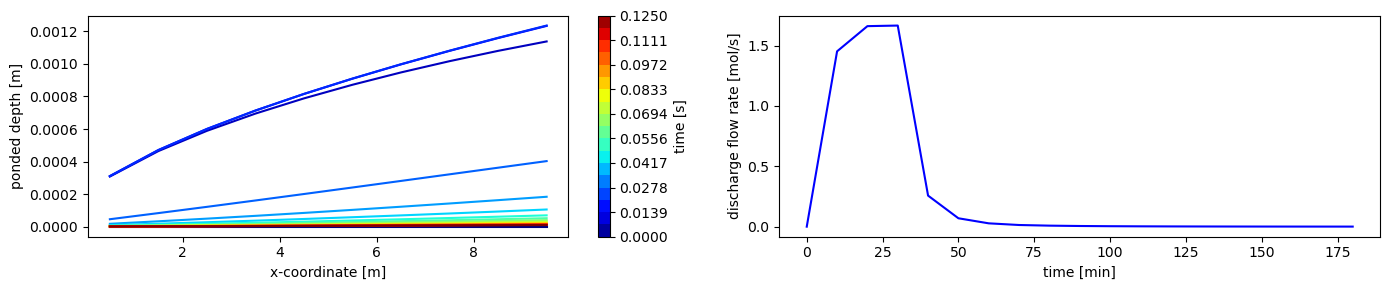

In [26]:
plot_surface("overland_flow/run_zero_gradient_results")

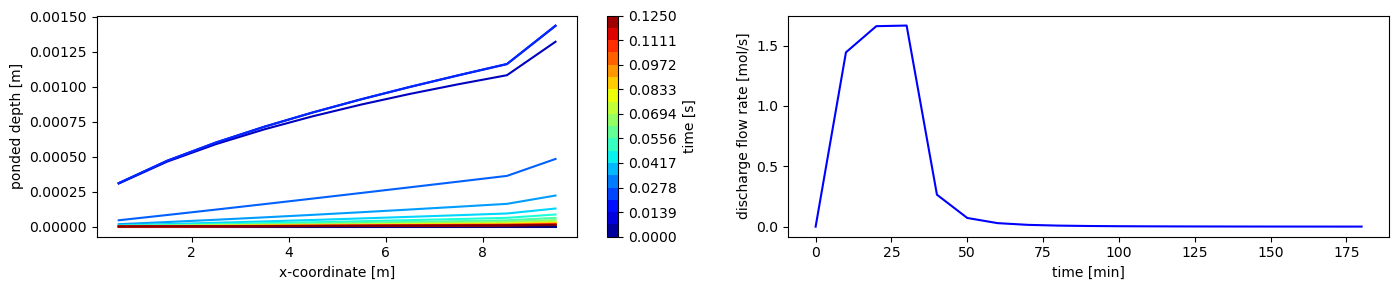

In [27]:
plot_surface("overland_flow/run_max_head_results")

# Integrated Hydrology

## Model Setup: No flow model

It's much more fun to run simulations with real data. 

<center>
<img src="hillslope_domain2.png" width=45%>
<img src="hillslope_domain1.png" width=45%>
</center>

The jupyter notebook we used to generate this mesh is included in the repository for you to use to generate finer and higher quality meshes.

### Initial and Boundary Conditions

**Initial Condition for spinup simulation**

* Subsurface: hydrostatic head -1 m below surface.
* Surface: consistent with subsurface IC
  

**Subsurface flow**
```xml
      <ParameterList name="initial conditions" type="ParameterList">
          <Parameter name="hydrostatic head [m]" type="double" value="-1.0"/>
          <Parameter name="hydrostatic water density [kg m^-3]" type="double" value="997.0"/>
      </ParameterList>
```
**Surface flow**
```xml
      <ParameterList name="initial conditions" type="ParameterList">
        <Parameter name="initialize surface head from subsurface" type="bool" value="true"/>
      </ParameterList>
```      

**Boundary Conditions**

* Subsurface: default no flow conditions
* Surface: surface seepage face 0.1m 

**Subsurface flow**
```xml
      <ParameterList name="boundary conditions" type="ParameterList">
      </ParameterList>
``` 
**Surface flow**
```xml
      <ParameterList name="boundary conditions" type="ParameterList">
        <ParameterList name="seepage face head">
          <ParameterList name="surface">
            <Parameter name="regions" type="Array(string)" value="{surface outlet}" />
            <ParameterList name="boundary head">
              <ParameterList name="function-constant">
                <Parameter name="value" type="double" value=" 0.1" />
              </ParameterList>
            </ParameterList>
          </ParameterList>
        </ParameterList>
      </ParameterList>
```       

**Simulation Scenario**

* Constant light rain at 0.00864mm per day for 1000 days 

```xml
<!-- the water source is a constant rate (m / s) -->
      <ParameterList name="surface-water_source" type="ParameterList">
        <Parameter name="evaluator type" type="string" value="independent variable constant"/>
        <Parameter name="value" type="double" value="1.e-9"/>
      </ParameterList>
```      

(0.0, 5e-06)

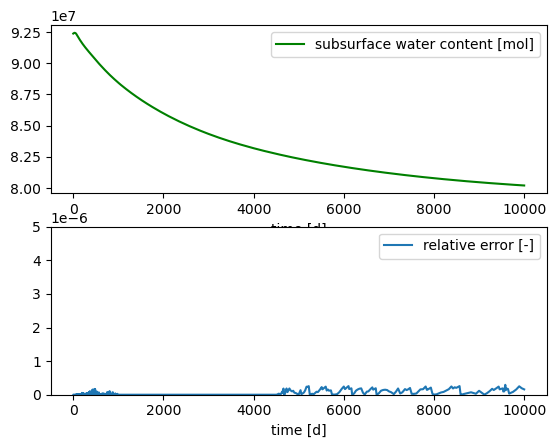

In [65]:
# load the water balance set of observations
data = pandas.read_csv("integrated_hydrology/run_hillslope_spinup_results/water_balance.dat", comment='#')
mol_rho = 55000

subsurface_water = data['subsurface water content [mol]'].to_numpy()
surface_water = data['surface water content [mol]'].to_numpy()
surface_runoff = data['runoff [mol d^-1]'].to_numpy()
precip = data['rain precipitation [m d^-1]'].to_numpy()

# compute the mass balance error
error = np.abs(
    (subsurface_water[1:] + surface_water[1:]) \
    - (subsurface_water[:-1] + surface_water[:-1]) \
    - (mol_rho * precip[1:] - surface_runoff[1:])
)       
data['relative error [-]'] = np.concatenate([np.zeros((1,),'d'), error]) / (subsurface_water + surface_water)

# plot
fig, axs = plt.subplots(2,1)

# demonstrate we are at steady-state
data.plot('time [d]', 'subsurface water content [mol]', ax=axs[0], color='g')
data.plot('time [d]', 'relative error [-]', ax=axs[1])
plt.ylim([0, 5e-6])
plt.tight_layout()


In [66]:
import colors
from matplotlib import colorbar

def plot_sat(v, v_surf, i, ax, bar=True):
    """Helper function that plots saturation across a transect"""
    sat = v.get("saturation_liquid", v.cycles[i])
    poly = v.getMeshPolygons(cmap='cool_r', linewidth=0.1, edgecolor='gray')
    poly.set_array(sat)
    poly.set_clim(0.4,1)
    pos=ax.add_collection(poly)
    if (bar):
        plt.colorbar(pos)

    elev = v_surf.get('surface-elevation', v.cycles[i])
    pd = v_surf.get('surface-ponded_depth', v.cycles[i])

    ax.plot(v_surf.centroids[:,0], elev+pd, 'b', linewidth=2)
    ax.set_title(f"{np.round(v.times[i])} days. Saturation.")

def plot_vel(v, v_surf, i, ax, bar=True, component='x', lim=1.e-7):
    """Helper function to plot Darcy velocity field."""
    vel = v.get(f"darcy_velocity.{component}", v.cycles[i])
    poly = v.getMeshPolygons(cmap='jet_r', linewidth=0.1, edgecolor='gray')
    poly.set_array(vel)
    poly.set_clim([-lim, lim])
    #poly.set_clim([-4.0e-8, 8.0e-7])
    pos = ax.add_collection(poly)
    if (bar):
        plt.colorbar(pos)

    elev = v_surf.get('surface-elevation', v.cycles[i])
    pd = v_surf.get('surface-ponded_depth', v.cycles[i])

    ax.plot(v_surf.centroids[:,0], elev+pd, 'b', linewidth=2)
    ax.set_title(f"{np.round(vis.times[i])} days. Velocity.{component}")

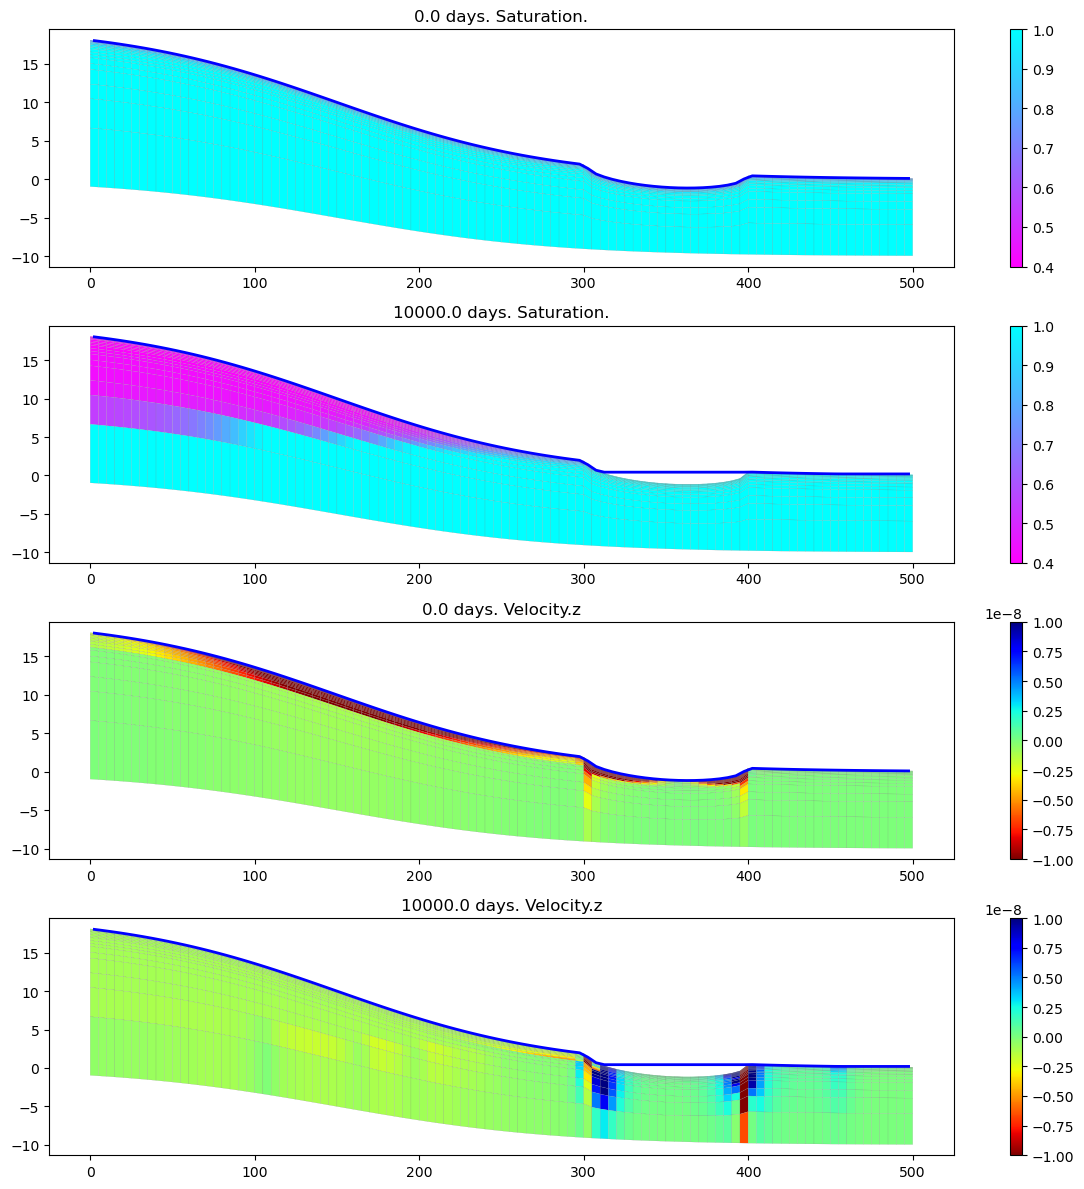

In [67]:
# load the spinup data
vis = ats_xdmf.VisFile(directory="integrated_hydrology/run_hillslope_spinup_results/", output_time_unit='d')

# select first (initial) and last (steady-state)
vis.filterIndices([0,-1])

# load mesh as polygons
vis.loadMeshPolygons()

# load the surface spinup data
vis_surf = ats_xdmf.VisFile(directory="integrated_hydrology/run_hillslope_spinup_results/", 
                            domain="surface",
                            output_time_unit='d')
#select same output as subsurface
vis_surf.filterIndices([0,-1])
vis_surf.loadMesh(order=['x',])

fig, axs = plt.subplots(4, 1, figsize=(12, 12))
plot_sat(vis, vis_surf, 0, axs[0])
plot_sat(vis, vis_surf, 1, axs[1])
plot_vel(vis, vis_surf, 0, axs[2], component='z', lim=1.e-8)
plot_vel(vis, vis_surf, 1, axs[3], component='z', lim=1.e-8)
plt.tight_layout()

## Model Setup: lakeside model

**Create new region**

```xml
    <ParameterList name="lakeside" type="ParameterList">
      <ParameterList name="region: plane" type="ParameterList">
        <Parameter name="point" type="Array(double)" value="{500.0, 1.0, 0.0}"/>
        <Parameter name="normal" type="Array(double)" value="{1.0, 0.0, 0.0}"/>
      </ParameterList>
    </ParameterList>
```    
  

**Boundary Condition**

* Subsurface: hydrostatic condition on the lakeside.
* Surface: surface seepage face 0.1m 

**Subsurface flow**
```xml
      <ParameterList name="boundary conditions" type="ParameterList">
        <ParameterList name="pressure" type="ParameterList">
    	  <ParameterList name="east" type="ParameterList">
            <Parameter name="regions" type="Array(string)" value="{lakeside}"/>
            <ParameterList name="boundary pressure">
              <ParameterList name="function-linear" type="ParameterList">
		      <Parameter name="x0" type="Array(double)" value="{0.0, 0.0, 0.0, -1.0}"/>
		      <Parameter name="y0" type="double" value="101325.0"/>
		      <Parameter name="gradient" type="Array(double)" value="{0.0, 0.0, 0.0, -9777.23 }"/>
              </ParameterList>
            </ParameterList>	      
          </ParameterList>
        </ParameterList>
      </ParameterList>
``` 
**Surface flow**
```xml
      <ParameterList name="boundary conditions" type="ParameterList">
        <ParameterList name="seepage face head">
          <ParameterList name="surface">
            <Parameter name="regions" type="Array(string)" value="{surface outlet}" />
            <ParameterList name="boundary head">
              <ParameterList name="function-constant">
                <Parameter name="value" type="double" value=" 0.1" />
              </ParameterList>
            </ParameterList>
          </ParameterList>
        </ParameterList>
      </ParameterList>
```       

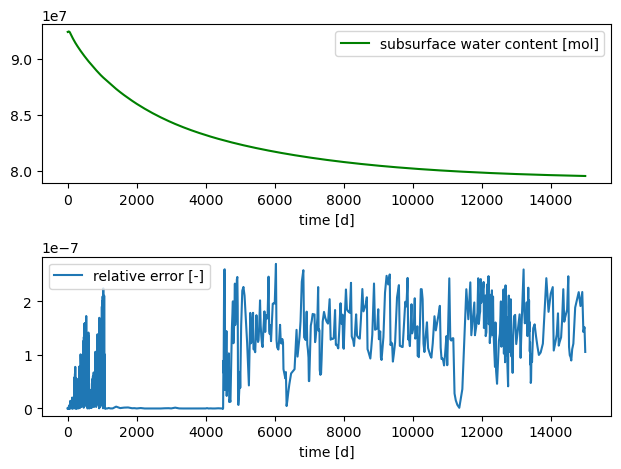

In [68]:
data = pandas.read_csv("integrated_hydrology/run_hillslope_spinup_open_results/water_balance.dat", comment='#')
mol_rho = 55000

subsurface_water = data['subsurface water content [mol]'].to_numpy()
surface_water = data['surface water content [mol]'].to_numpy()
surface_runoff = data['runoff surface [mol d^-1]'].to_numpy()
subsurface_runoff = data['runoff subsurface [mol d^-1]'].to_numpy()
precip = data['rain precipitation [m d^-1]'].to_numpy()

# compute the mass balance error
error = np.abs(
    (subsurface_water[1:] + surface_water[1:]) \
    - (subsurface_water[:-1] + surface_water[:-1]) \
    - (mol_rho * precip[1:] - subsurface_runoff[1:] - surface_runoff[1:])
)       
data['relative error [-]'] = np.concatenate([np.zeros((1,),'d'), error]) / (subsurface_water + surface_water)

# plot
fig, axs = plt.subplots(2,1)

# demonstrate we are at steady-state
data.plot('time [d]', 'subsurface water content [mol]', ax=axs[0], color='g')
data.plot('time [d]', 'relative error [-]', ax=axs[1])
plt.tight_layout()


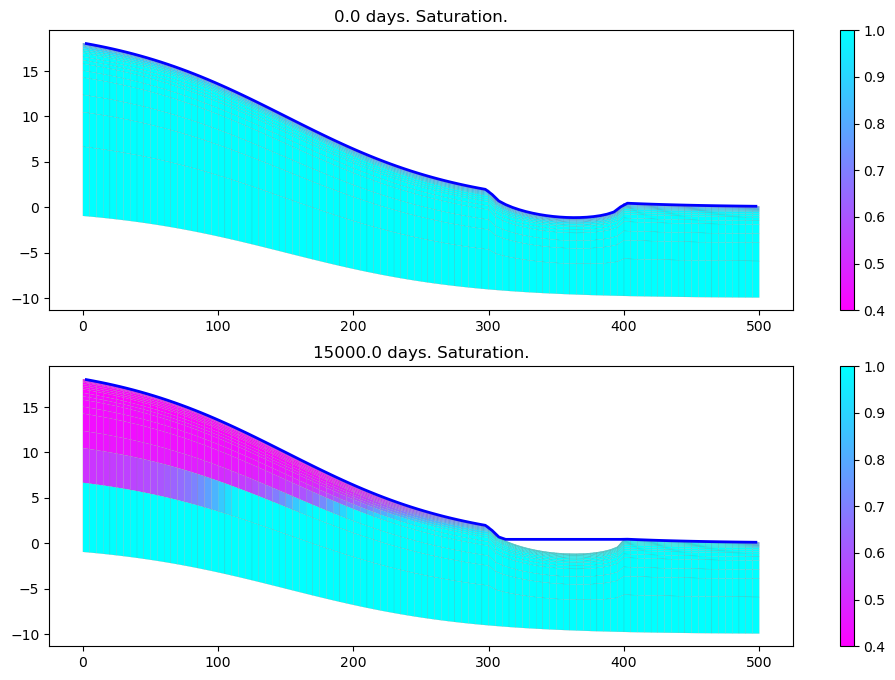

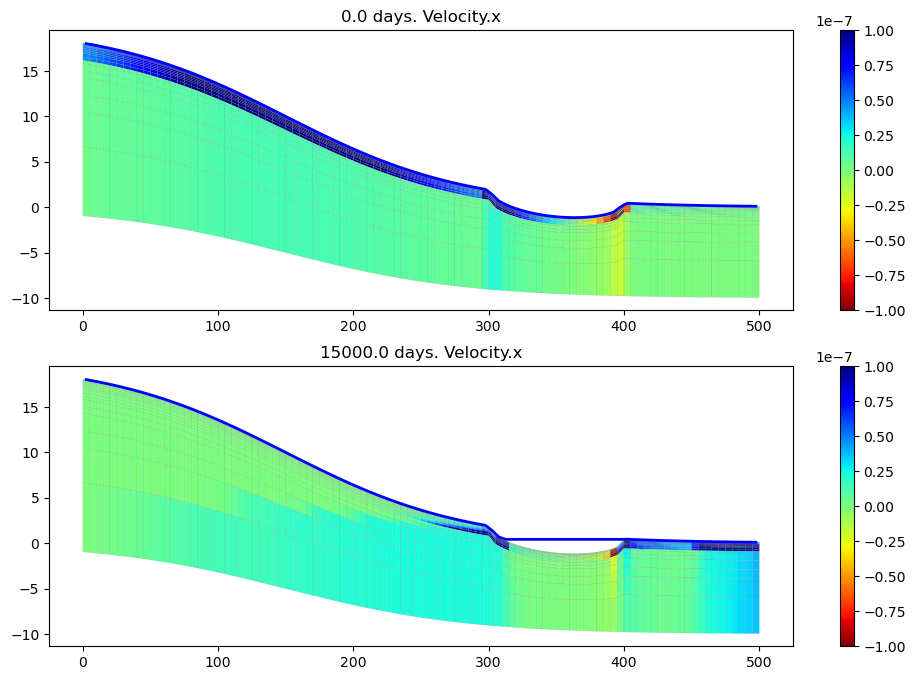

In [69]:
# open boundary condition
directory = 'integrated_hydrology/run_hillslope_spinup_open_results/'

# load the file
vis = ats_xdmf.VisFile(directory=directory, output_time_unit='d')

# filter to first and last times saved
vis.filterIndices([0, -1])
vis.loadMeshPolygons()

vis_surf = ats_xdmf.VisFile(directory=directory, domain="surface", output_time_unit='d')

# select same output as subsurface
vis_surf.filterIndices([0,-1])
vis_surf.loadMesh(order=['x',])
 

fig, axs = plt.subplots(2,1,figsize=(12,8))
plot_sat(vis, vis_surf, 0, axs[0], True)
plot_sat(vis, vis_surf, 1, axs[1], True)

fig, axs = plt.subplots(2,1,figsize=(12,8))
plot_vel(vis, vis_surf, 0, axs[0], True)
plot_vel(vis, vis_surf, 1, axs[1], True)



## Model Setup: Irrigation model

**Create new regions**

```xml
  <ParameterList name="golf course" type="ParameterList">
      <Parameter name="region type" type="string" value="labeled set"/>
      <Parameter name="label" type="string" value="14"/>
      <Parameter name="file" type="string" value="../../data/hillslope_mesh.exo"/>
      <Parameter name="format" type="string" value="Exodus II"/>
      <Parameter name="entity" type="string" value="face"/>
    </ParameterList>
    <ParameterList name="forested" type="ParameterList">
      <Parameter name="region type" type="string" value="labeled set"/>
      <Parameter name="label" type="string" value="15"/>
      <Parameter name="file" type="string" value="../../data/hillslope_mesh.exo"/>
      <Parameter name="format" type="string" value="Exodus II"/>
      <Parameter name="entity" type="string" value="face"/>
    </ParameterList>
```    

**Initial conditions**

**Subsurface**
```xml
      <ParameterList name="initial conditions" type="ParameterList">
        <Parameter name="restart file" type="string" value="../run_hillslope_spinup_open_results/checkpoint_final.h5"/>
      </ParameterList>
  <ParameterList name="golf course" type="ParameterList">
      <Parameter name="region type" type="string" value="labeled set"/>
      <Parameter name="label" type="string" value="14"/>
      <Parameter name="file" type="string" value="../../data/hillslope_mesh.exo"/>
      <Parameter name="format" type="string" value="Exodus II"/>
      <Parameter name="entity" type="string" value="face"/>
    </ParameterList>
    <ParameterList name="forested" type="ParameterList">
      <Parameter name="region type" type="string" value="labeled set"/>
      <Parameter name="label" type="string" value="15"/>
      <Parameter name="file" type="string" value="../../data/hillslope_mesh.exo"/>
      <Parameter name="format" type="string" value="Exodus II"/>
      <Parameter name="entity" type="string" value="face"/>
    </ParameterList>
```   
**Surface flow**
```xml
      <ParameterList name="initial conditions" type="ParameterList">
        <Parameter name="initialize surface head from subsurface" type="bool" value="true"/>
      </ParameterList>
```      

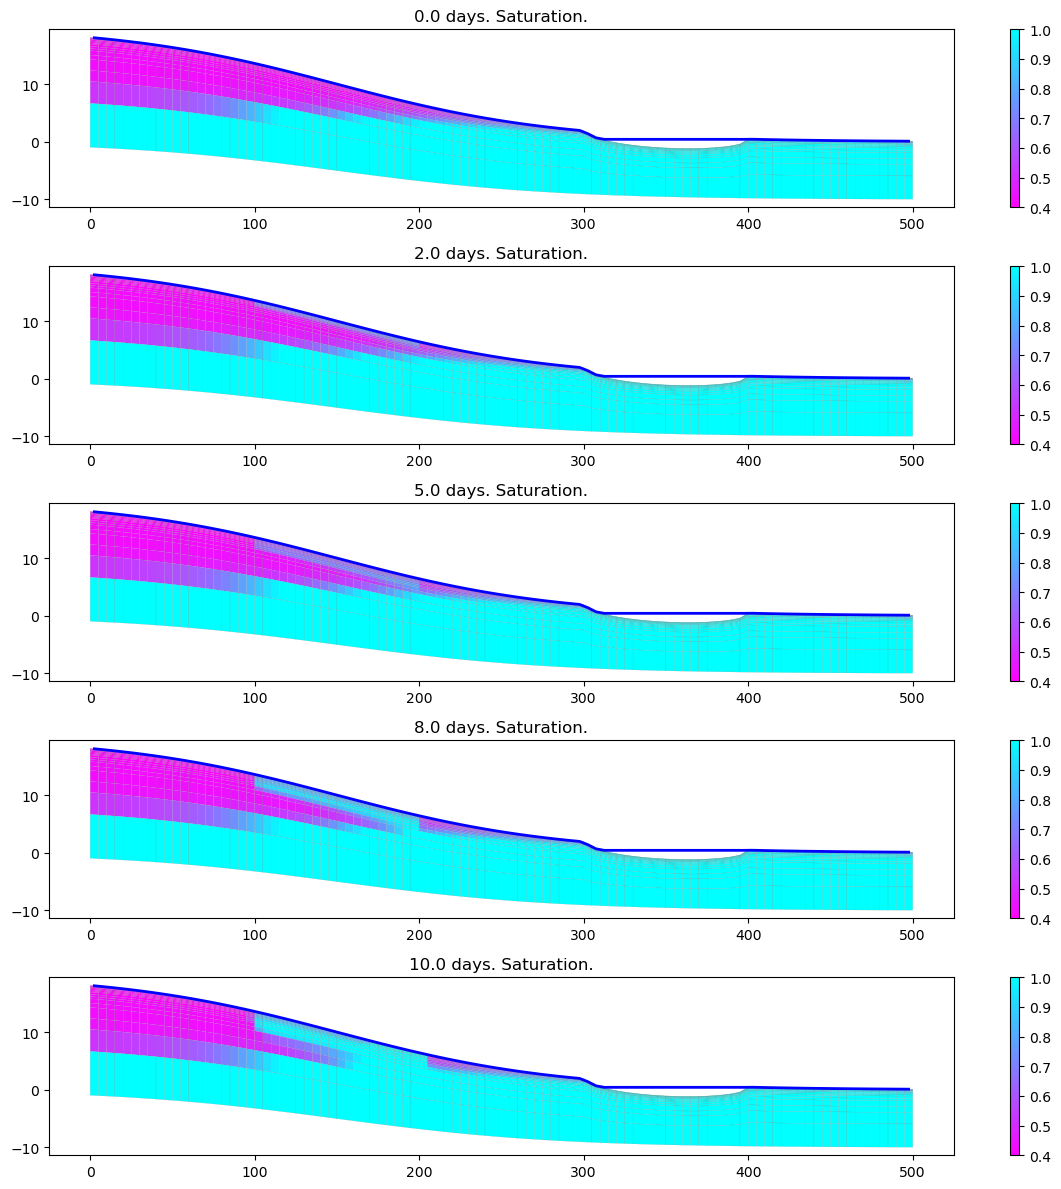

In [70]:
vis = ats_xdmf.VisFile(directory="integrated_hydrology/run_hillslope_irrigation_results/", 
                       output_time_unit='d')

# select output every 2 days
vis.filterIndices([0,20,40,60,80])
vis.loadMeshPolygons()

vis_surf = ats_xdmf.VisFile(directory="integrated_hydrology/run_hillslope_irrigation_results/", 
                            domain="surface", 
                            output_time_unit='d')

# select same output as subsurface
vis_surf.filterIndices([0,20,40,60,80])
vis_surf.loadMesh(order=['x',])

fig, axs = plt.subplots(5,1,figsize=(12,12))
plot_sat(vis, vis_surf, 0, axs[0])
plot_sat(vis, vis_surf, 1, axs[1])
plot_sat(vis, vis_surf, 2, axs[2])
plot_sat(vis, vis_surf, 3, axs[3])
plot_sat(vis, vis_surf, 4, axs[4])
plt.tight_layout()
